# Learning a map from random noise to target distribution (posterior known up to a constant)

Yadong Lu Dec 13th

We explore the idea of using neural network to wrap a source of random noise into a flexible ditribution which is then used to approximate a target distribution. From now on, we explore a simple discrepency measure, i.e. KL divergence between an implicit distribution q(x) and a target distribution p(x) which is known up to a constant. 

As a starting point, we set p(x) to be a mixture of normal without knowing the normalizing constant. x ~ 0.5*N(-3,1) + 0.5*N(3,1)

We use an auxillary distribution $p^{*}(x)$ to minimize the KL divergence:

$E_{q}log \frac{q(x)}{p(x)} = E_{q}log \frac{q(x)}{p^{*}(x)} + E_{q}log \frac{p^{*}(x)}{p(x)}$

We let $p^{*}(x) = N(0,5)$. $E_{q}log \frac{p^{*}(x)}{p(x)}$ is easy to estimate through sampling from q and use monte carlo estimation, after taking the gradient is constance in p(x) goes away. The problem becomes to estimate $E_{q}log \frac{q(x)}{p^{*}(x)}$. We use the proposition 1. from https://arxiv.org/abs/1406.2661. When the discriminator D(x) is trained to convergence, then $-log\frac{D(G(z))}{1-D(G(z))} = E_{q}log \frac{q(x)}{p^{*}(x)}$  

In [171]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="3"
from IPython import display
import time
from scipy.stats import norm
# from tensorflow.examples.tutorials.mnist import input_data
# mnist = input_data.read_data_sets('MNIST_data')

We make functions to sample from the target distribution. 'sample_z' is for sampling the uniform noise that is injected to a generator neural network. The input of the generator is a n dimensional vector where each dimension is an independent uniform noise between -20 to 20. We input 'batch_size' number of n-dim vectors so that the output of the generator is 'batch_size' number of scalars. 

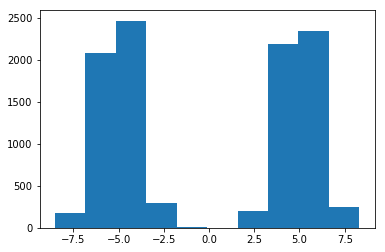

In [160]:
def mix_norm(x):
    return 0.5*np.exp(-(x-1)**2/2) + 0.5*np.exp(-(x+1)**2/2)
# plt.plot(np.linspace(-5,5,1000),[mix_norm(x) for x in np.linspace(-5,5,1000)],linestyle=linestyles[0], label='Mix normal uptoconstant')

def sample_data(n=10000, mn=[1,-1], sd=[1,1]):
    data = np.zeros(n)
    z = np.random.binomial(1, 0.5, size=n)#.astype('float')
    component0 =  np.random.normal(loc=mn[0], scale=sd[0], size=n)
    component1 =  np.random.normal(loc=mn[1], scale=sd[1], size=n)
#     component2 =  np.random.normal(loc=mn[], scale=sd[1], size=n)
    for i in range(n):
        if z[i] ==0:
            data[i] = component0[i]
        else:
            data[i] = component1[i]
    return data
data = sample_data(10000, [5,-5], [1,1])
plt.hist(data)

def sample_Z(batch_size, n):
    '''Uniform prior for G(Z)'''
#     return np.random.normal(loc=0, scale=1, size=[batch_size, n])
    return np.random.uniform(-20., 20., size=[batch_size, n])

Below we build the tensorflow graph. The auxillary distibution we use is a flat normal distribution N(0,10).

In [215]:
tf.reset_default_graph()

def generator(Z, hsize=[64, 64], reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.relu) 
        h2_drop = tf.nn.dropout(h2,keep_prob=0.7)
        h3 = tf.layers.dense(h2_drop, hsize[1],activation=tf.nn.relu) 
        h4 = tf.layers.dense(h3,hsize[1],activation=tf.nn.relu) 
        h4_drop = tf.nn.dropout(h4,keep_prob=0.7)
        out = tf.layers.dense(h4_drop,1)

    return out


def discriminator(X ,hsize=[64, 64] ,reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.relu)
        h3 = tf.layers.dense(h2,1)
        out = tf.nn.sigmoid( h3 ) # transform to probability

    return out, h3

X = tf.placeholder(tf.float32,[None,1])
Z = tf.placeholder(tf.float32,[None,10])

G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample,reuse=True)

disc_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1-D_fake))
gen_loss = tf.reduce_mean(-D_logit_fake + (-tf.square(G_sample)/(2*25)) -
                          tf.log( 0.5*tf.exp(-tf.square(G_sample-3)/2) + 0.5*tf.exp(-tf.square(G_sample+3)/2)+1e-10)) ##tf.log(1/np.sqrt(2*np.pi)) +

# gen_loss = tf.reduce_mean(-D_logit_fake  -
#                           tf.log( 0.5*tf.exp(-tf.square(G_sample-3)/2) + 0.5*tf.exp(-tf.square(G_sample+3)/2)) ) ##tf.log(1/np.sqrt(2*np.pi)) +

print(D_real.shape, G_sample.shape)

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.AdamOptimizer(learning_rate=0.0005).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.AdamOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step


(?, 1) (?, 1)


Note here we do stochastic gradient descent (sgd) for the disciminator 30 times so that it is close to convergence and then we keep the discriminator the same and do sgd 2 times for the generator. 

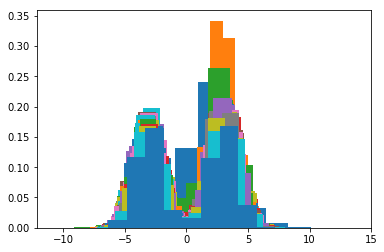

In [216]:
batch_size = 1024
sess = tf.Session()
sess.run(tf.global_variables_initializer())
fix_data = np.random.normal(loc=0, scale=5, size=batch_size).reshape(batch_size,1)
# fix_data = np.random.uniform(-50., 50., size=[batch_size, 1])
for i in range(4001):
    for j in range(30):
        X_batch = fix_data # sample_data(batch_size, [5,-5], [1,1]).reshape(batch_size,1)
        Z_batch = sample_Z(batch_size, 10)
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    for k in range(2):
#         Z_batch = sample_Z(batch_size, 5)
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})
    if i % 100 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss) )
        G_sample_val = sess.run(G_sample, feed_dict={Z: sample_Z(10000, 10)} )
        print(np.mean(G_sample_val))
        plt.hist(G_sample_val, normed=True)
#         plt.plot(np.linspace(-5,5,2000),[0.5*(norm.pdf(x,-3,1) + norm.pdf(x,3,1)) for x in np.linspace(-5,5,1000)],\
#                  linestyle='-',  )

        display.display(plt.gcf())
        display.clear_output(wait=True)


In [236]:
# batch_size = 1024
# sess = tf.Session()
# sess.run(tf.global_variables_initializer())
# for i in range(10001):
#     X_batch = np.random.normal(loc=0, scale=1, size=batch_size).reshape(batch_size,1) #sample_data(batch_size, [5,-5], [1,1]).reshape(batch_size,1)
#     Z_batch = sample_Z(batch_size, 5)#.reashape(batch_size,5)
#     _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
#     _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})
#     if i % 500 == 0:
#         print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss) )

# Results

Below we look at the samples output by the generator neural network. The sampled histogram is compared with the density function of mixture  x ~ 0.5N(-3,1) + 0.5N(3,1). As we can see, they are very close to each other. 

In [234]:
G_sample_val, D_fake_val, D_real_val = sess.run([G_sample,D_fake,D_real], feed_dict={Z: sample_Z(10000, 10),X: X_batch} )
# plt.hist(G_sample_val)
X_batch = np.random.normal(loc=0, scale=1, size=batch_size).reshape(batch_size,1) #sample_data(batch_size, [5,-5], [1,1]).reshape(batch_size,1)
Z_batch = sample_Z(batch_size, 10)
D_fake_val, D_real_val = sess.run([D_fake,D_real], feed_dict={X: X_batch, Z: Z_batch})
print( np.max(D_fake_val), np.max(D_real_val))
print( np.mean(D_fake_val), np.mean(D_real_val))

0.996382 0.901958
0.349559 0.692233


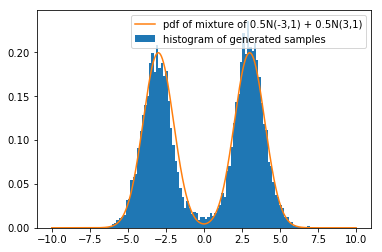

In [242]:
plt.hist(G_sample_val, normed=True,bins=90, label = 'histogram of generated samples')
plt.plot(np.linspace(-10,10,2000),[0.5*(norm.pdf(x,-3,1) + norm.pdf(x,3,1)) for x in np.linspace(-10,10,2000)],\
         linestyle='-'  ,label='pdf of mixture of 0.5N(-3,1) + 0.5N(3,1)')
plt.legend()